# Conceptual

Q: Explain the differences between bagging and boosting and explain how machine
learning methods in general use these strategies to build robust models using tree
models?

Both are ensamble techniques. In bagging we select bootstrap datasets from the training data and fit one tree for each boostrap dataset. So all trees can be fitted in parralel. To make predictions, all fitted trees are used to make a prediction about the new data. To aggregate the predictions of all trees, one calculates a mean (regression) or selects the mode (classification) as the final prediction.

In boosting, we build the tree sequentially, because each tree depends on his predecessor. This dependency comes from the fact, that each successor tree is fitted by the residuals of his predecessor. However, each sucessing tree comes with a different weight, when it comes the prediction, which is also different to bagging.

As I said, both techniques result in an ensamle of models to make predictions. Im machine learning this is used to create a better fits the response better than every model individually. This way one can reduce errors caused by a high bias, each individual model could have.

Q: What are the main differences between Random Forests and AdaBoost regarding how
the base learners are trained, how samples are weighted, how predictions are made and
how robust are they regarding overfitting?

# Practical

### I: Load the data and get an overview of the data

In [12]:
from ISLP import load_data

df = load_data("Carseats")

In [13]:
predictors_and_response = df.columns[1:]
print(len(predictors_and_response))
print(predictors_and_response.values)

10
['CompPrice' 'Income' 'Advertising' 'Population' 'Price' 'ShelveLoc' 'Age'
 'Education' 'Urban' 'US']


In [14]:
from pandas.api.types import is_numeric_dtype

for column in predictors_and_response.values:
    if is_numeric_dtype(df[column]):
        print(f'{df[column].describe()}\n')
    else:
        print(f'{df[column].value_counts()}\n')

count    400.000000
mean     124.975000
std       15.334512
min       77.000000
25%      115.000000
50%      125.000000
75%      135.000000
max      175.000000
Name: CompPrice, dtype: float64

count    400.000000
mean      68.657500
std       27.986037
min       21.000000
25%       42.750000
50%       69.000000
75%       91.000000
max      120.000000
Name: Income, dtype: float64

count    400.000000
mean       6.635000
std        6.650364
min        0.000000
25%        0.000000
50%        5.000000
75%       12.000000
max       29.000000
Name: Advertising, dtype: float64

count    400.000000
mean     264.840000
std      147.376436
min       10.000000
25%      139.000000
50%      272.000000
75%      398.500000
max      509.000000
Name: Population, dtype: float64

count    400.000000
mean     115.795000
std       23.676664
min       24.000000
25%      100.000000
50%      117.000000
75%      131.000000
max      191.000000
Name: Price, dtype: float64

Medium    219
Bad        96
Good       

In [16]:
len(df)

400

In [17]:
df.head(20)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
5,10.81,124,113,13,501,72,Bad,78,16,No,Yes
6,6.63,115,105,0,45,108,Medium,71,15,Yes,No
7,11.85,136,81,15,425,120,Good,67,10,Yes,Yes
8,6.54,132,110,0,108,124,Medium,76,10,No,No
9,4.69,132,113,0,131,124,Medium,76,17,No,Yes


             CompPrice    Income  Advertising  Population     Price       Age  \
CompPrice     1.000000 -0.080653    -0.024199   -0.094707  0.584848 -0.100239   
Income       -0.080653  1.000000     0.058995   -0.007877 -0.056698 -0.004670   
Advertising  -0.024199  0.058995     1.000000    0.265652  0.044537 -0.004557   
Population   -0.094707 -0.007877     0.265652    1.000000 -0.012144 -0.042663   
Price         0.584848 -0.056698     0.044537   -0.012144  1.000000 -0.102177   
Age          -0.100239 -0.004670    -0.004557   -0.042663 -0.102177  1.000000   
Education     0.025197 -0.056855    -0.033594   -0.106378  0.011747  0.006488   

             Education  
CompPrice     0.025197  
Income       -0.056855  
Advertising  -0.033594  
Population   -0.106378  
Price         0.011747  
Age           0.006488  
Education     1.000000  


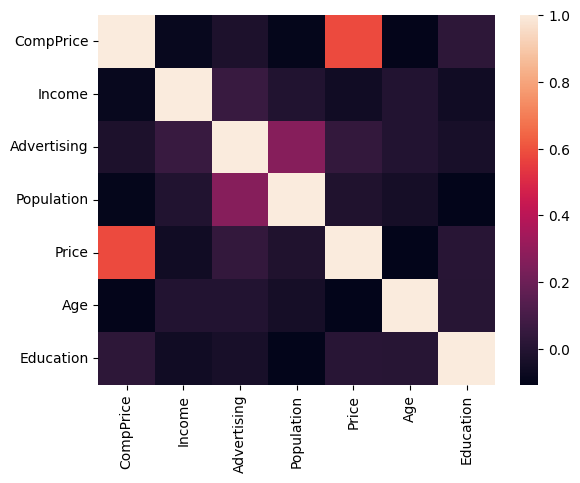

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_predictors = []
for col in predictors_and_response:
    if is_numeric_dtype(df[col]):
        numeric_predictors.append(col)

cm = df[numeric_predictors].corr()
print(cm)
sns.heatmap(cm)
plt.show()

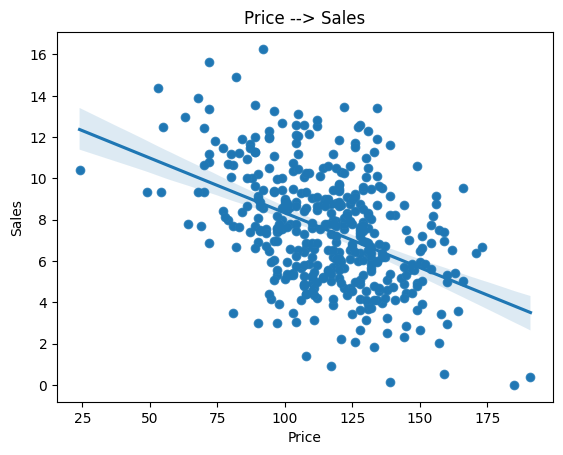

In [19]:
sns.scatterplot(df, x='Price', y='Sales')
sns.regplot(df, x='Price', y='Sales',)
plt.title(f'Price --> Sales')
plt.show()

#### I: Interprete the results.

### I: Learn and assess Classification Trees

In [20]:
high = df['Sales'].apply(lambda s: "Yes" if s > 8 else "No")
high

0      Yes
1      Yes
2      Yes
3       No
4       No
      ... 
395    Yes
396     No
397     No
398     No
399    Yes
Name: Sales, Length: 400, dtype: object

In [97]:
from sklearn.tree import DecisionTreeClassifier as DTC
from ISLP.models import ModelSpec as MS
import numpy as np
from sklearn.metrics import accuracy_score ,log_loss

design = MS(df.columns.drop('Sales'), intercept=False)

X = design.fit_transform(df)
feature_names = X.columns.values
y = high

clf = DTC(random_state=0)
clf.fit(X, y)

acc = accuracy_score(y , clf.predict(X))
dev = np.sum(log_loss(y , clf.predict_proba(X)))
print(f'Missclassification error: {1-acc}')
print(f'Residual mean deviance: {dev}')


Missclassification error: 0.0
Residual mean deviance: 2.2204460492503136e-16


|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- ShelveLoc[Medium] <= 0.50
|   |   |   |   |--- class: No
|   |   |   |--- ShelveLoc[Medium] >  0.50
|   |   |   |   |--- class: Yes
|   |   |--- Income >  57.00
|   |   |   |--- Population <= 207.50
|   |   |   |   |--- Age <= 56.50
|   |   |   |   |   |--- Price <= 88.00
|   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |--- Price >  88.00
|   |   |   |   |   |   |--- class: No
|   |   |   |   |--- Age >  56.50
|   |   |   |   |   |--- Income <= 102.00
|   |   |   |   |   |   |--- Population <= 30.50
|   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |--- Population >  30.50
|   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Income >  102.00
|   |   |   |   |   |   |--- class: Yes
|   |   |   |--- Population >  207.50
|   |   |   |   |--- Income <= 115.00
|   |   |   |   |   |--- class: Yes
|   |   |   |   |--- Income >  115.00
|   |   |   |   

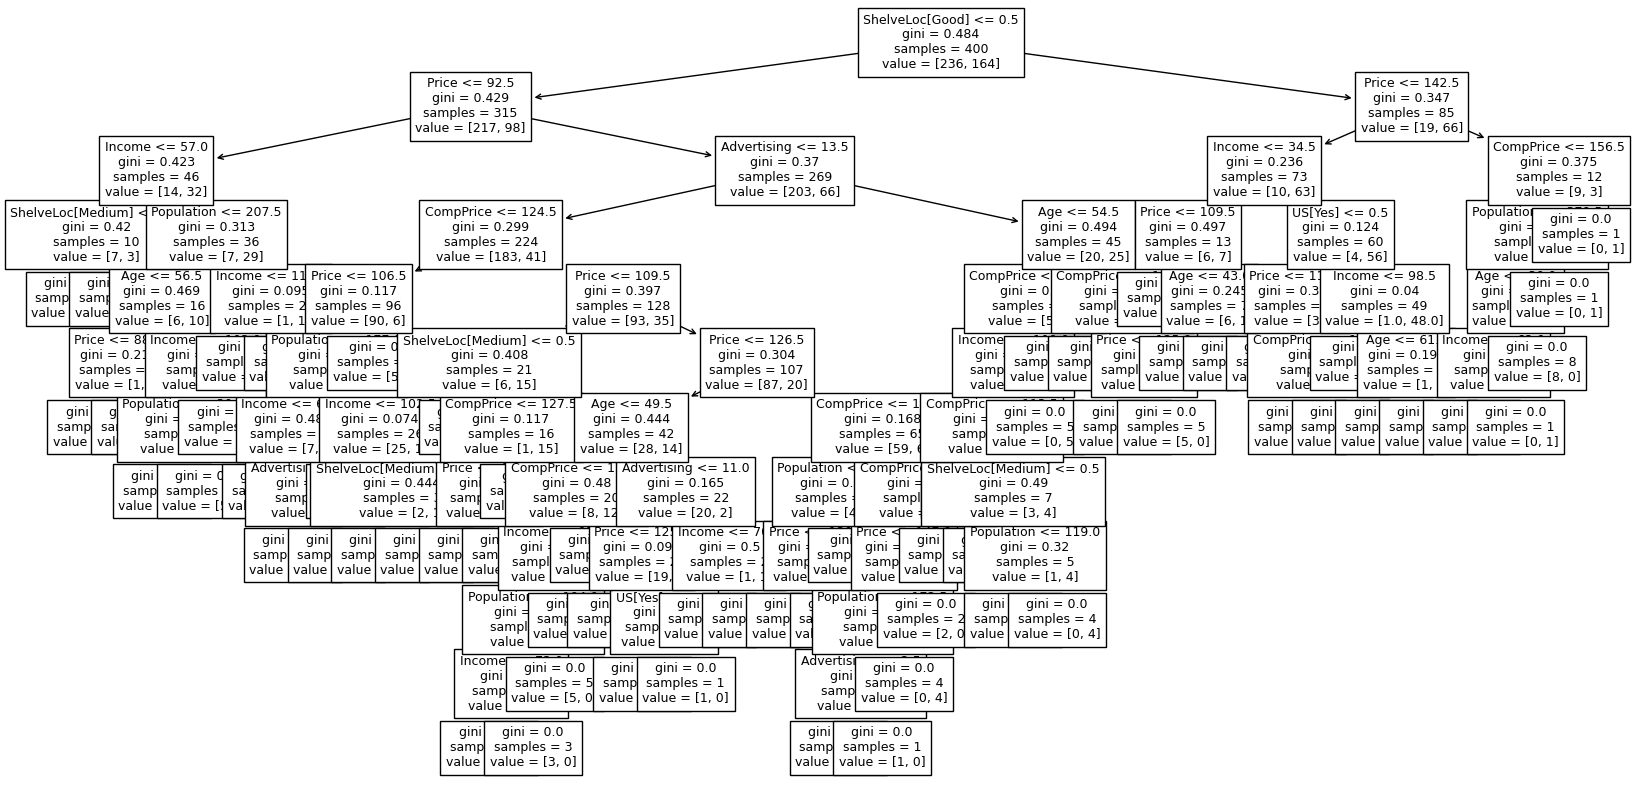

In [98]:
from sklearn.tree import plot_tree, export_text

print(export_text(clf, feature_names=feature_names))

plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=feature_names, fontsize=9)
plt.show()

#### I: Interprete the results

In [113]:
from sklearn.model_selection import train_test_split
from ISLP import load_data , confusion_table

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=1)

clf = DTC(random_state=0)
clf.fit(X_train, y_train)

acc = accuracy_score(y_test , clf.predict(X_test))
dev = np.sum(log_loss(y_test , clf.predict_proba(X_test)))
print(f'Missclassification error: {1-acc}')
print(f'Residual mean deviance: {dev}')

confusion = confusion_table(clf.predict(X_test), y_test)
confusion


Missclassification error: 0.31999999999999995
Residual mean deviance: 11.533969084517489


Truth,No,Yes
Predicted,,
No,87,32
Yes,32,49


### I: Interprete the results

In [114]:
from sklearn.model_selection import KFold, GridSearchCV
import pandas as pd


ccp_path = clf.cost_complexity_pruning_path(X_train, y_train)
kfold = KFold (8, random_state=1, shuffle=True)

grid = GridSearchCV(clf, 
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, y_train)
results = pd.DataFrame(grid.cv_results_)
results[['param_ccp_alpha', 'mean_test_score']]

,param_ccp_alpha,mean_test_score
0,0.0,0.730
1,0.003261,0.730
2,0.0045,0.730
3,0.00625,0.735
4,0.007364,0.735
5,0.0075,0.735
6,0.0075,0.735
7,0.008,0.735
8,0.008571,0.740
9,0.00875,0.750


#### I: Interprete the results.

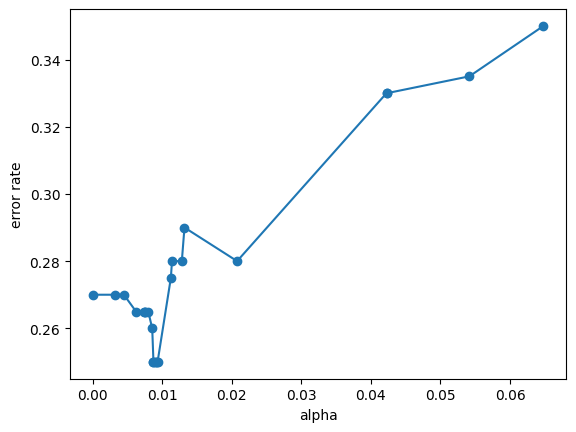

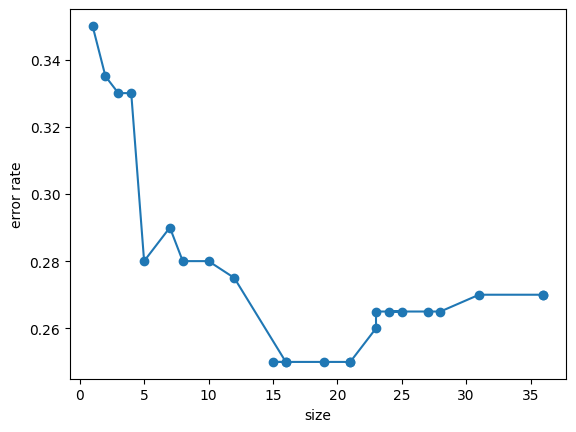

In [115]:
plt.plot(results['param_ccp_alpha'], results['mean_test_score'].apply(lambda s : 1-s), marker="o")
plt.xlabel('alpha')
plt.ylabel('error rate')
plt.show()

# with the library I used for cross validation, I can accesss only the best model. 
# Therefore, I need to fit all the validated models again to get access to their sizes. 

sizes = []
for model_params in results['params']:
    tclf = DTC(**model_params)
    tclf.fit(X_train, y_train)
    max_depth = tclf.tree_.n_leaves
    sizes.append(max_depth)


plt.plot(sizes, results['mean_test_score'].apply(lambda s : 1-s), marker="o")
plt.xlabel('size')
plt.ylabel('error rate')
plt.show()


#### I: Interprete the results.

|--- feature_5 <= 0.50
|   |--- feature_4 <= 106.50
|   |   |--- feature_7 <= 60.50
|   |   |   |--- feature_0 <= 103.50
|   |   |   |   |--- feature_4 <= 80.00
|   |   |   |   |   |--- class: Yes
|   |   |   |   |--- feature_4 >  80.00
|   |   |   |   |   |--- class: No
|   |   |   |--- feature_0 >  103.50
|   |   |   |   |--- class: Yes
|   |   |--- feature_7 >  60.50
|   |   |   |--- feature_3 <= 30.50
|   |   |   |   |--- class: Yes
|   |   |   |--- feature_3 >  30.50
|   |   |   |   |--- feature_4 <= 79.50
|   |   |   |   |   |--- class: Yes
|   |   |   |   |--- feature_4 >  79.50
|   |   |   |   |   |--- class: No
|   |--- feature_4 >  106.50
|   |   |--- feature_2 <= 13.50
|   |   |   |--- feature_0 <= 147.50
|   |   |   |   |--- class: No
|   |   |   |--- feature_0 >  147.50
|   |   |   |   |--- feature_4 <= 147.00
|   |   |   |   |   |--- feature_3 <= 324.50
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- feature_3 >  324.50
|   |   |   |   |   |   |--- class: 

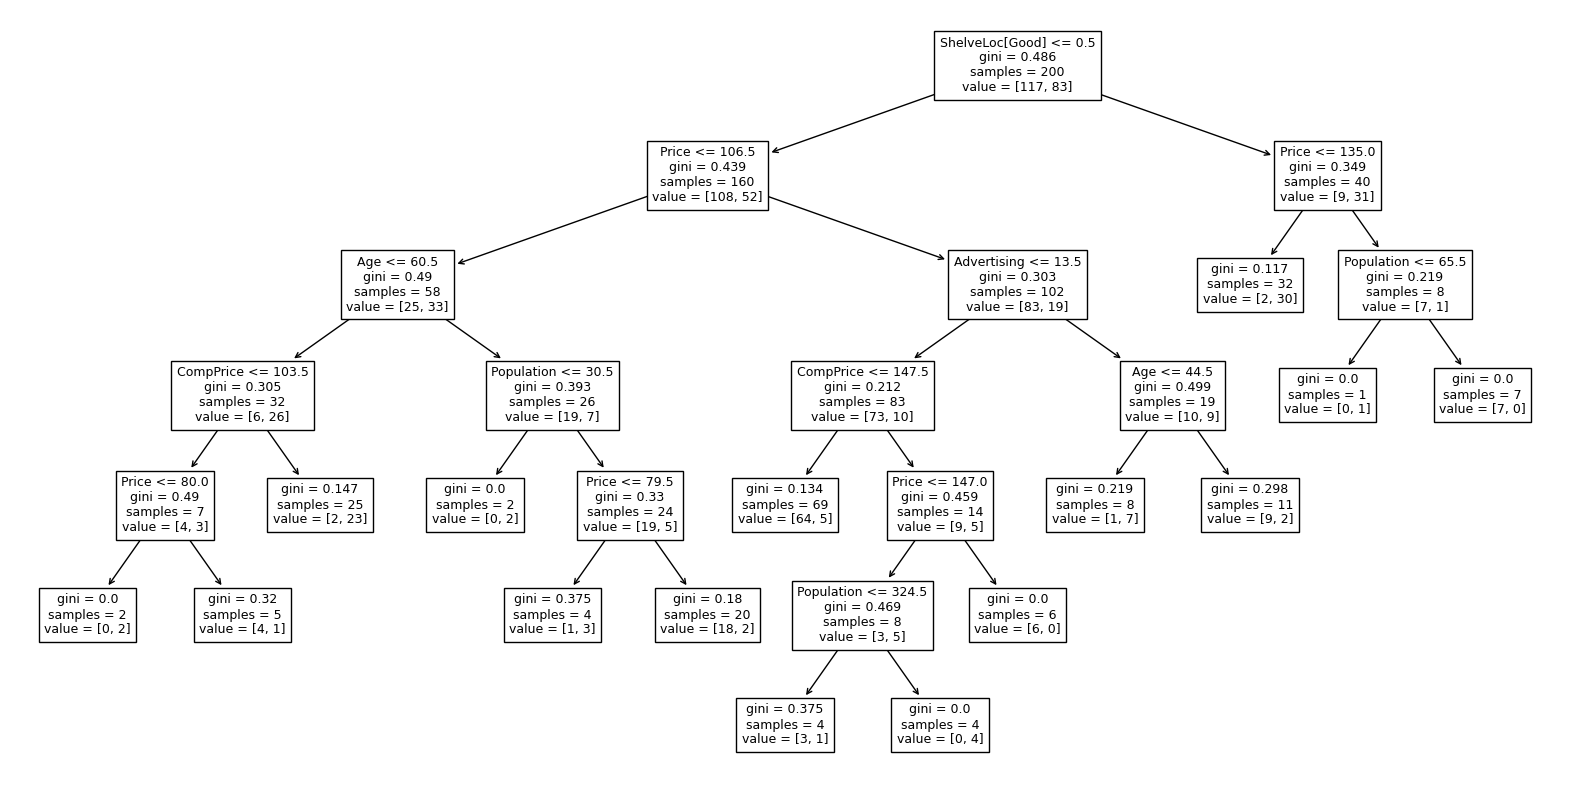

In [117]:
# In my case a size of 15 seems to be reasonable

best = DTC(max_leaf_nodes=15, random_state=0)
best.fit(X_train, y_train)

print(export_text(best))

plt.figure(figsize=(20, 10))
plot_tree(best, feature_names=feature_names, fontsize=9)
plt.show()


In [118]:
acc = accuracy_score(y_test , best.predict(X_test))
dev = np.sum(log_loss(y_test , best.predict_proba(X_test)))
print(f'Missclassification error: {1-acc}')
print(f'Residual mean deviance: {dev}')

confusion = confusion_table(best.predict(X_test), y_test)
confusion

Missclassification error: 0.26
Residual mean deviance: 2.1932734523566477


Truth,No,Yes
Predicted,,
No,96,29
Yes,23,52


In [126]:
# in my case i have to go much higher with the size, i.e. to 36

bigger_worst = DTC(max_leaf_nodes=36, random_state=0)
bigger_worst.fit(X_train, y_train)


acc = accuracy_score(y_test , bigger_worst.predict(X_test))
dev = np.sum(log_loss(y_test , bigger_worst.predict_proba(X_test)))
print(f'Missclassification error: {1-acc}')
print(f'Residual mean deviance: {dev}')

confusion = confusion_table(bigger_worst.predict(X_test), y_test)
confusion




Missclassification error: 0.275
Residual mean deviance: 9.912004682007217


Truth,No,Yes
Predicted,,
No,95,31
Yes,24,50


|--- feature_5 <= 0.50
|   |--- feature_4 <= 106.50
|   |   |--- feature_7 <= 60.50
|   |   |   |--- feature_0 <= 103.50
|   |   |   |   |--- feature_4 <= 80.00
|   |   |   |   |   |--- class: Yes
|   |   |   |   |--- feature_4 >  80.00
|   |   |   |   |   |--- feature_2 <= 17.50
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- feature_2 >  17.50
|   |   |   |   |   |   |--- class: Yes
|   |   |   |--- feature_0 >  103.50
|   |   |   |   |--- feature_3 <= 448.00
|   |   |   |   |   |--- class: Yes
|   |   |   |   |--- feature_3 >  448.00
|   |   |   |   |   |--- feature_0 <= 122.00
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- feature_0 >  122.00
|   |   |   |   |   |   |--- class: Yes
|   |   |--- feature_7 >  60.50
|   |   |   |--- feature_3 <= 30.50
|   |   |   |   |--- class: Yes
|   |   |   |--- feature_3 >  30.50
|   |   |   |   |--- feature_4 <= 79.50
|   |   |   |   |   |--- feature_1 <= 76.50
|   |   |   |   |   |   |--- class: No
|   |   |   |

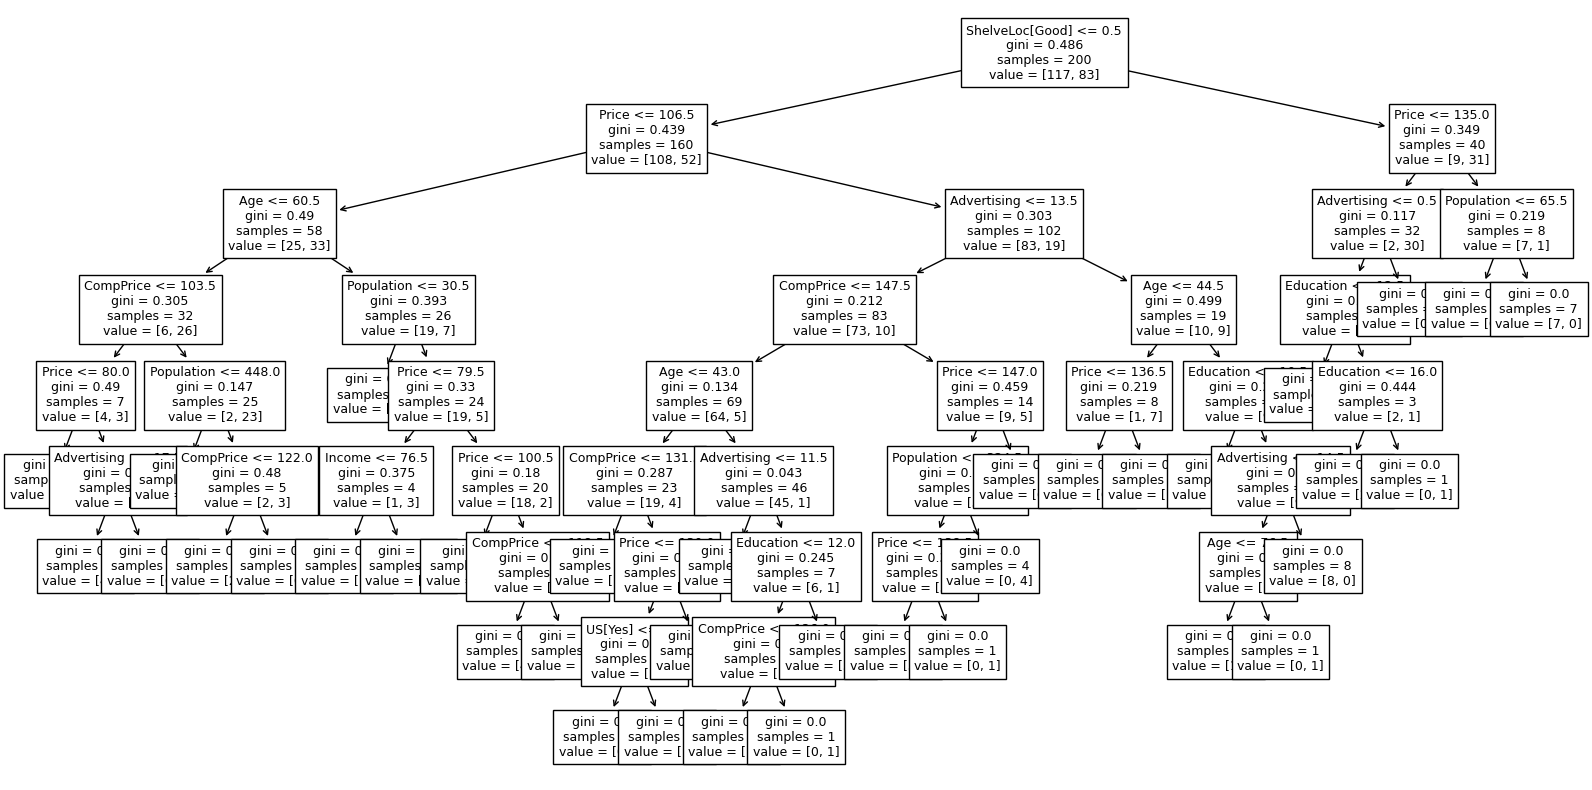

In [127]:
print(export_text(bigger_worst))

plt.figure(figsize=(20, 10))
plot_tree(bigger_worst, feature_names=feature_names, fontsize=9)
plt.show()

#### I: Interprete the results

### I: Learn and assess Regression Trees

In [192]:
#df = load_data('Boston') #this loads a dataframe without the 'black' predictor, which shinks the predictor number
df = pd.read_csv('../data/ISLR/data/Boston.csv')

In [193]:
df.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [194]:
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.metrics import mean_squared_error

design = MS(df.columns.drop('medv'), intercept=False)

X = design.fit_transform(df)
feature_names = list(X.columns)
y = df['medv']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=1)

reg = DTR(random_state=0)
reg.fit(X_train, y_train)

dev = np.sum(mean_squared_error(y_test , reg.predict(X_test)))
print(f'Residual mean deviance: {dev}')
print(f'Number of terminal nodes: {reg.tree_.n_leaves}')

Residual mean deviance: 21.104743083003953
Number of terminal nodes: 238


|--- feature_13 <= 9.76
|   |--- feature_6 <= 7.51
|   |   |--- feature_8 <= 1.56
|   |   |   |--- value: [50.00]
|   |   |--- feature_8 >  1.56
|   |   |   |--- feature_6 <= 6.80
|   |   |   |   |--- feature_6 <= 6.13
|   |   |   |   |   |--- feature_6 <= 5.97
|   |   |   |   |   |   |--- feature_8 <= 9.90
|   |   |   |   |   |   |   |--- feature_0 <= 37.00
|   |   |   |   |   |   |   |   |--- feature_12 <= 396.26
|   |   |   |   |   |   |   |   |   |--- value: [19.90]
|   |   |   |   |   |   |   |   |--- feature_12 >  396.26
|   |   |   |   |   |   |   |   |   |--- value: [18.90]
|   |   |   |   |   |   |   |--- feature_0 >  37.00
|   |   |   |   |   |   |   |   |--- feature_1 <= 0.08
|   |   |   |   |   |   |   |   |   |--- feature_8 <= 6.58
|   |   |   |   |   |   |   |   |   |   |--- value: [21.00]
|   |   |   |   |   |   |   |   |   |--- feature_8 >  6.58
|   |   |   |   |   |   |   |   |   |   |--- value: [20.90]
|   |   |   |   |   |   |   |   |--- feature_1 >  0.08
|   |   |  

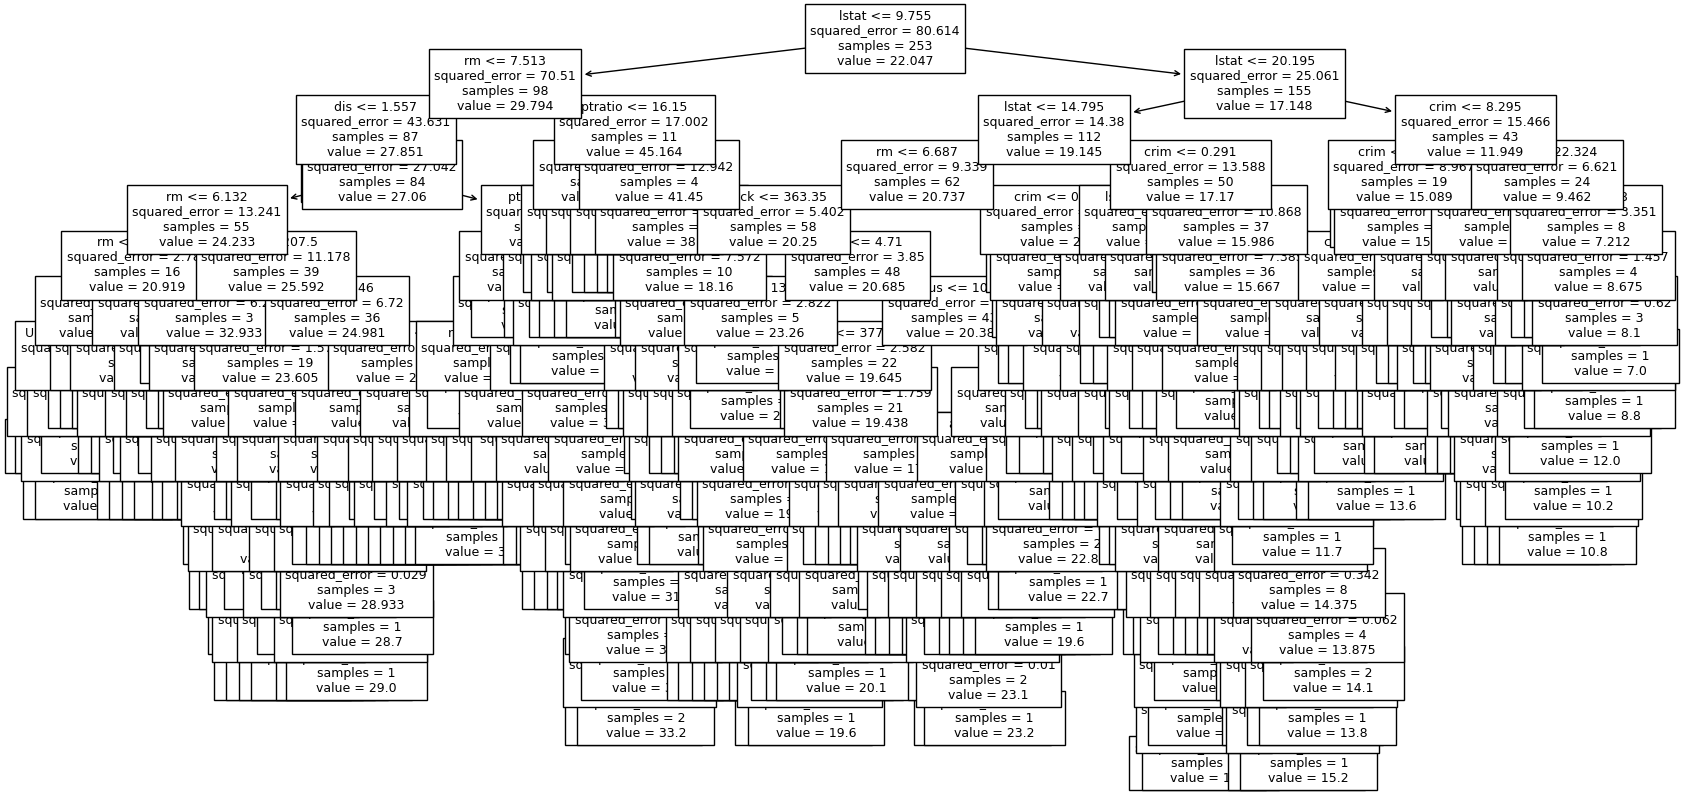

In [195]:
print(export_text(reg))

plt.figure(figsize=(20, 10))
plot_tree(reg, feature_names=feature_names, fontsize=9)
plt.show()

#### I: Interprete the results.

In [196]:

ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = KFold (8, random_state=1, shuffle=True)

grid = GridSearchCV(reg, 
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
results = pd.DataFrame(grid.cv_results_)
results[['param_ccp_alpha', 'mean_test_score']]

,param_ccp_alpha,mean_test_score
0,0.0,-24.734248
1,0.0,-24.734248
2,0.0,-24.734248
3,0.00002,-24.734248
4,0.00002,-24.734248
...,...,...
226,5.031675,-34.613287
227,6.025119,-35.798063
228,6.359063,-37.528310
229,11.56946,-44.682808


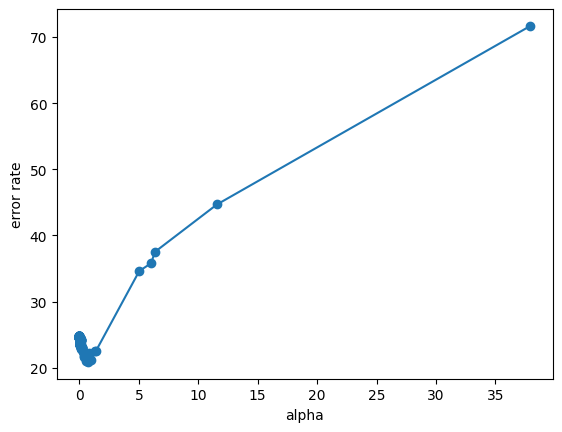

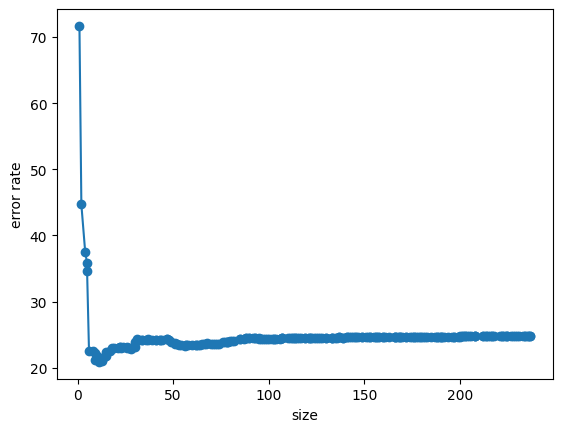

In [197]:
plt.plot(results['param_ccp_alpha'], results['mean_test_score'].apply(lambda s : s*(-1)), marker="o")
plt.xlabel('alpha')
plt.ylabel('error rate')
plt.show()

# with the library I used for cross validation, I can accesss only the best model. 
# Therefore, I need to fit all the validated models again to get access to their sizes. 

sizes = []
for model_params in results['params']:
    treg = DTR(**model_params)
    treg.fit(X_train, y_train)
    max_depth = treg.tree_.n_leaves
    sizes.append(max_depth)

results['size'] = sizes

plt.plot(results['size'], results['mean_test_score'].apply(lambda s : s*(-1)), marker="o")
plt.xlabel('size')
plt.ylabel('error rate')
plt.show()


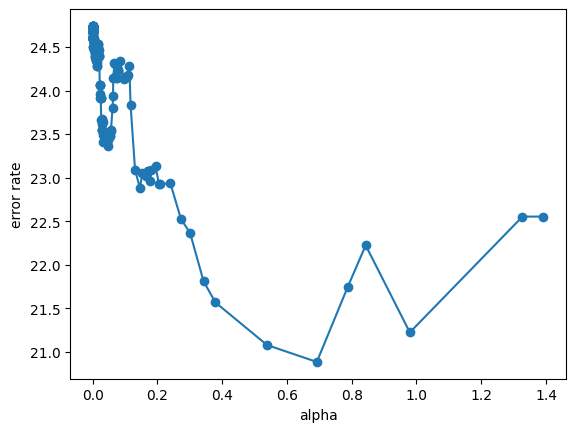

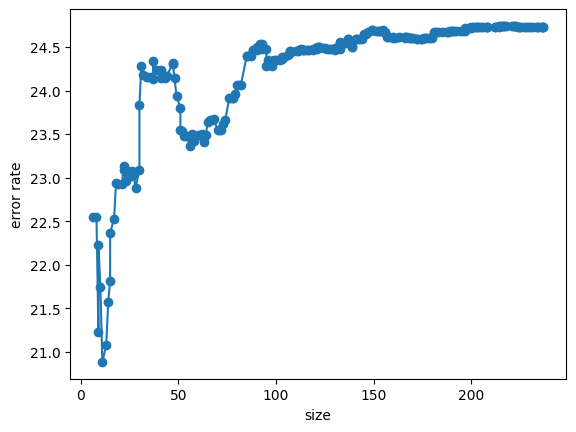

In [198]:
# Zoom in to the intervall containing the lowest values

plt.plot(results[results['param_ccp_alpha'] < 3]['param_ccp_alpha'], 
         results[results['param_ccp_alpha'] < 3]['mean_test_score'].apply(lambda s : s*(-1)), 
         marker="o")
plt.xlabel('alpha')
plt.ylabel('error rate')
plt.show()

plt.plot(results[results['param_ccp_alpha'] < 3]['size'], 
         results[results['param_ccp_alpha'] < 3]['mean_test_score'].apply(lambda s : s*(-1)), 
         marker="o")
plt.xlabel('size')
plt.ylabel('error rate')
plt.show()

#### I: Interprete the results

16.699962099402416


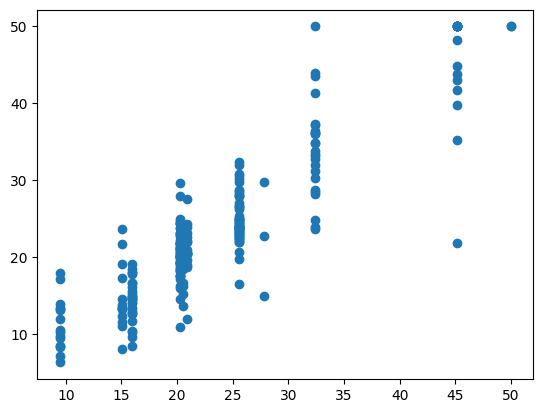

In [199]:
pred = grid.best_estimator_.predict(X_test)
print(mean_squared_error(y_test, pred))

plt.scatter(pred, y_test)
plt.show()

#### I: Interprete the results.

### I: Learn and assess Regression Bagging (Trees) and Random Forests

In [201]:
from sklearn.ensemble import RandomForestRegressor as RF


rf = RF(n_estimators=500, max_features=X_train.shape[1], random_state=0)
rf.fit(X_train, y_train)

print(f'MSE: {mean_squared_error(y_train, rf.predict(X_train))}')
print(f'Numbers of tree: {len(rf.estimators_)}')

MSE: 1.9520314238735057
Numbers of tree: 500


MSE: 11.45571849169965


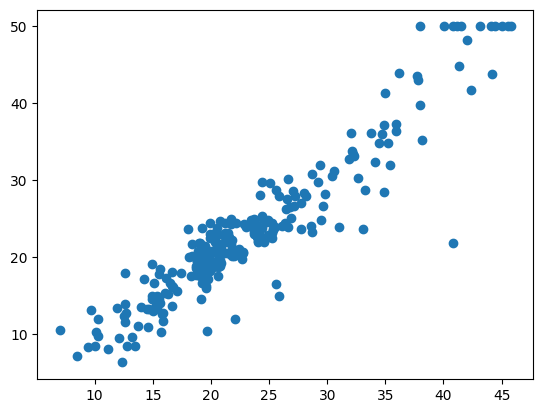

In [202]:

pred = rf.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, pred)}')

plt.scatter(pred, y_test)
plt.show()

In [203]:
rf = RF(n_estimators=25, max_features=X_train.shape[1], random_state=0)
rf.fit(X_train, y_train)

print(f'MSE: {mean_squared_error(y_test, rf.predict(X_test))}')
print(f'Numbers of tree: {len(rf.estimators_)}')

MSE: 11.988357438735179
Numbers of tree: 25


#### I: Interprete the results

Numbers of tree: 500
MSE: 11.227801746719399


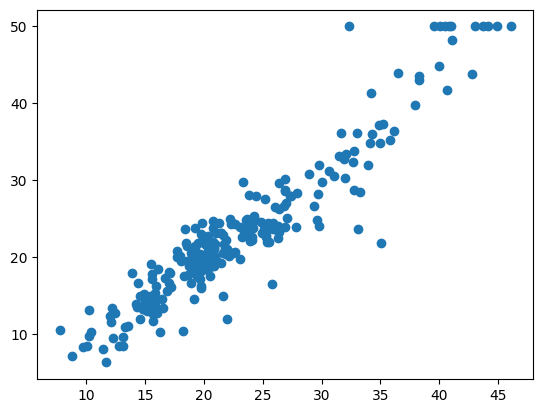

In [205]:
rf = RF(n_estimators=500, max_features=6, random_state=0)
rf.fit(X_train, y_train)

print(f'Numbers of tree: {len(rf.estimators_)}')

pred = rf.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, pred)}')

plt.scatter(pred, y_test)
plt.show()

#### I: Interprete the results.

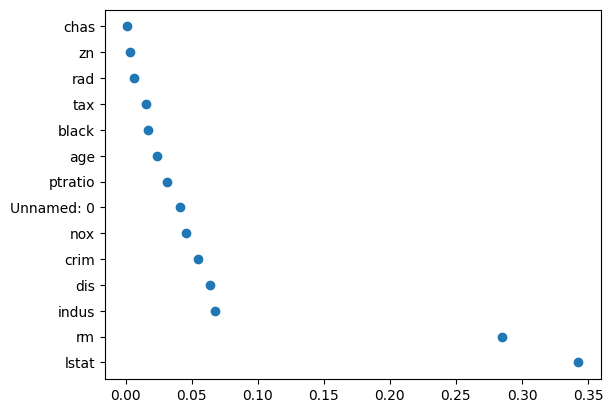

,importance
lstat,0.342463
rm,0.284840
indus,0.067678
dis,0.063654
crim,0.054682
nox,0.046069
Unnamed: 0,0.041546
ptratio,0.031343
age,0.024127
black,0.016844


In [206]:
feature_imp = pd.DataFrame({'importance ':rf.feature_importances_},
                           index=feature_names)
feature_imp = feature_imp.sort_values(by='importance ', ascending=False)



plt.scatter(feature_imp, feature_imp.index.values)
plt.show()

feature_imp

#### I: Interprete the results

### I: Learn and assess Regression Boosting (Trees)

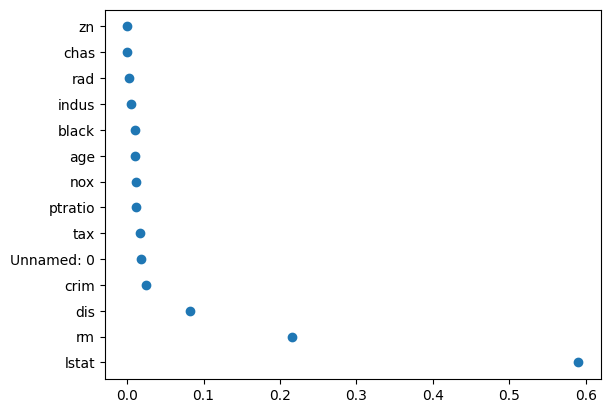

,importance
lstat,0.589794
rm,0.215196
dis,0.081877
crim,0.024930
Unnamed: 0,0.018542
tax,0.017228
ptratio,0.012372
nox,0.011681
age,0.010499
black,0.010131


In [209]:
from sklearn.ensemble import GradientBoostingRegressor as GBR


boost = GBR(n_estimators=5000, max_features=X_train.shape[1], random_state=0, learning_rate=0.001, max_depth=4)
boost.fit(X_train, y_train)


feature_imp = pd.DataFrame({'importance ':boost.feature_importances_},
                           index=feature_names)
feature_imp = feature_imp.sort_values(by='importance ', ascending=False)



plt.scatter(feature_imp, feature_imp.index.values)
plt.show()

feature_imp

#### I: Interprete the results

In [210]:
print(f'MSE: {mean_squared_error(y_test, boost.predict(X_test))}')

MSE: 10.319583876170126


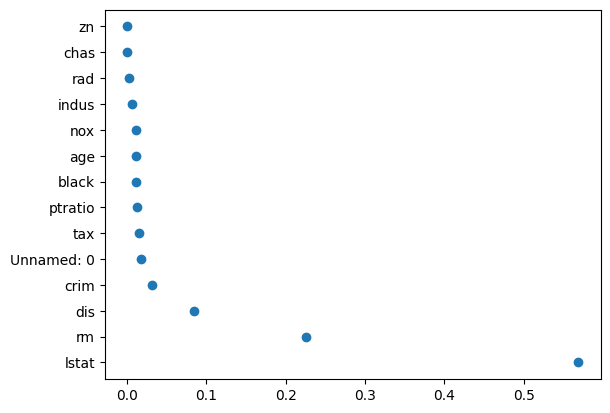

            importance 
lstat          0.568634
rm             0.226267
dis            0.084036
crim           0.031423
Unnamed: 0     0.017335
tax            0.015739
ptratio        0.012521
black          0.011767
age            0.011504
nox            0.011337
indus          0.006520
rad            0.002217
chas           0.000484
zn             0.000217
MSE: 10.25998879833088


In [211]:
boost = GBR(n_estimators=5000, max_features=X_train.shape[1], random_state=0, learning_rate=0.2, max_depth=4)
boost.fit(X_train, y_train)

feature_imp = pd.DataFrame({'importance ':boost.feature_importances_},
                           index=feature_names)
feature_imp = feature_imp.sort_values(by='importance ', ascending=False)



plt.scatter(feature_imp, feature_imp.index.values)
plt.show()

print(feature_imp)

print(f'MSE: {mean_squared_error(y_test, boost.predict(X_test))}')

#### I: Interpret the results